# **RNN for Music Generation**

This files uses an RNN with LSTM to generate music given a dataset with tunes matching a particular emotion.

## **General Imports**

Imports needed for the code below

In [1]:
!apt-get install -y lilypond

Reading package lists... Done
Building dependency tree       
Reading state information... Done
lilypond is already the newest version (2.20.0-1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import music21
import math
from music21 import * 

from torch.utils.data.sampler import SubsetRandomSampler
from google.colab import drive
from inspect import modulesbyfile
from collections import Counter
from IPython.display import Image, Audio
from sklearn.model_selection import train_test_split

import pandas as pd 
import random
import IPython
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys
import warnings

## Data Processing

This section goes over data preprocessing, which includes the following steps:


*   Load .mid files for a particular emotion
*   Extract notes from the .mid files 
*   Map notes to an index and vice versa 
*   One-hot-encode outputs
*   Generate training and validation datasets

Some processing code from: https://www.kaggle.com/code/karnikakapoor/music-generation-lstm/notebook



### **Mount to Drive**

Connect to Google Drive where all of the training and validation data is stored

In [3]:
# Data is stored on drive, mount personal drive to be able to access it 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Import .mid files from drive**

Import the .mid files for a given emotion. Repeat the process for all emotions.

In [4]:
# Load all the midi files for the given emotion
def load_midis(filepath):

    # Open .mid files and add to array
    midis = []
    for i in os.listdir(filepath):
        if i.endswith(".mid"):
            tr = filepath+i
            midi = converter.parse(tr)
            midis.append(midi)
    return midis

In [5]:
# Load files from both validation and training set for a given emotion 
def load_sets(emotion):
    filepath = "/content/gdrive/MyDrive/RNN Training/{0}/".format(emotion)
    training_midis = load_midis(filepath)

    filepath = "/content/gdrive/MyDrive/RNN Validation/{0}/".format(emotion)
    validation_midis = load_midis(filepath)

    return training_midis + validation_midis

angry_midis = load_sets("Angry")

### **Extract the notes from the midi files**

In [6]:
# Extract notes from the stream of midi files
def extract_notes(all_midis):
    notes = []
    notes_to_parse = None

    # Iterate through all the midi files in the given array 
    for tune in all_midis:
        # Separate the tune into different instrument parts 
        tune_instrument = instrument.partitionByInstrument(tune)
        for part in tune_instrument.parts:
            if 'Piano' in str(part):
                # Break the part from tune_instrument into elements 
                notes_to_parse = part.recurse()
                for element in notes_to_parse:
                    # If the element is a note, then add it to the list, but if element is a chord, then convert chord into individual notes
                    if isinstance(element, note.Note):
                        notes.append(str(element.pitch))
                    elif isinstance(element, chord.Chord):
                        notes.append(".".join(str(n) for n in element.normalOrder))
    return notes

# Remove any notes that do not occur too frequently - this is to reduce training time and focus on key notes 
def generate_mappings(notes):
    # Determine all the unique notes and their frequence
    unique_notes = list(set(notes))
    freq = dict(map(lambda x: (x, notes.count(x)), unique_notes))

    #dictionary having key as note index and value as note
    index_to_note_mapping = dict(enumerate(freq))
    
    #dictionary having key as note and value as note index
    note_to_index_mapping = dict(map(reversed, index_to_note_mapping.items()))
    
    return index_to_note_mapping, note_to_index_mapping

### **Map notes to an index and vice versa and split data into batches**

In [7]:
notes = extract_notes(angry_midis)
notes = notes[0:1000]

In [8]:
index_to_note, note_to_index = generate_mappings(notes)
unique_notes = list(set(notes))
length_unique_notes = len(unique_notes)

print(f"Total Notes: {len(notes)}")
print(f"Unique Notes: {length_unique_notes}")

Total Notes: 1000
Unique Notes: 411


In [9]:
# Use a window size of 16
# Given 16 input values, the model should be able to predict the 17th value (this is the target)
length = 16
features = []
targets = []

length_number_notes = len(notes)
num_notes = (length * math.floor(length_number_notes / length))

count = 0
for i in range(0, num_notes - length, 1):
    feature = notes[i:i + length]
    target = notes[i + length]

    features.append([note_to_index[j] for j in feature])
    targets.append(note_to_index[target])

In [10]:
inputs = torch.tensor(features, dtype=torch.float32).reshape(len(features), length, 1)
inputs = inputs / float(length_unique_notes)
outputs = torch.tensor(targets)

## **Model**

RNN model with LSTM from lecture

In [11]:
class MusicRNN(nn.Module):
    def __init__(self):
        super(MusicRNN, self).__init__()
        self.name = "Tune"
        self.lstm = nn.LSTM(input_size=1, hidden_size=256, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(256, length_unique_notes)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x

## **Training**



In [41]:
def get_model_name(name, batch_size, learning_rate, epoch, emotion):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}_emotion{4}".format(name, batch_size, learning_rate, epoch, emotion)
    return path

def train(model, emotion, train_loader, validation_loader, batch_size, num_epochs=5, 
          learning_rate=1e-3, plot=True):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, train_loss, validation_loss = [], [], []

    for epoch in range(num_epochs):
        # Train the model and append the train loss
        for inputs, output in train_loader:
            optimizer.zero_grad()
            pred = model(inputs)
            loss = criterion(pred, output)
            loss.backward()
            optimizer.step()
        
        train_loss.append(float(loss))
        
        # Compute validation loss
        for inputs, output in validation_loader:
            pred = model(inputs)
            loss = criterion(pred, output)
        validation_loss.append(float(loss))

        # Display information
        if plot:
            print(  f'Epoch {epoch}: '
                    f'\tTrain Loss: {train_loss[epoch]}'
                    f'\t\tValidation Loss: {validation_loss[epoch]} ')

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, emotion, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
        iters.append(epoch)

    print("=======================================")
    print("Final Training Loss: {}\n".format(train_loss[-1]))   
    print("Final Validation Loss: {}\n".format(train_loss[-1])) 

    #Plotting
    if plot:
        plt.title("Train vs. Validation Loss")
        plt.plot(iters, train_loss, label="Train")
        plt.plot(iters, validation_loss, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()

Epoch 0: 	Train Loss: 5.908631801605225		Validation Loss: 5.843544006347656 
Epoch 1: 	Train Loss: 6.014740467071533		Validation Loss: 6.126805305480957 
Epoch 2: 	Train Loss: 5.472938537597656		Validation Loss: 5.143319606781006 
Epoch 3: 	Train Loss: 5.5353007316589355		Validation Loss: 6.769095420837402 
Epoch 4: 	Train Loss: 5.8365607261657715		Validation Loss: 6.314128875732422 
Epoch 5: 	Train Loss: 5.91425895690918		Validation Loss: 6.446130752563477 
Epoch 6: 	Train Loss: 5.683465480804443		Validation Loss: 6.250282287597656 
Epoch 7: 	Train Loss: 5.642492771148682		Validation Loss: 6.638897895812988 
Epoch 8: 	Train Loss: 5.455079555511475		Validation Loss: 6.547704696655273 
Epoch 9: 	Train Loss: 5.457850933074951		Validation Loss: 5.735180854797363 
Epoch 10: 	Train Loss: 5.685278415679932		Validation Loss: 6.147919178009033 
Epoch 11: 	Train Loss: 5.4125142097473145		Validation Loss: 7.78609561920166 
Epoch 12: 	Train Loss: 5.583117961883545		Validation Loss: 4.374123573303

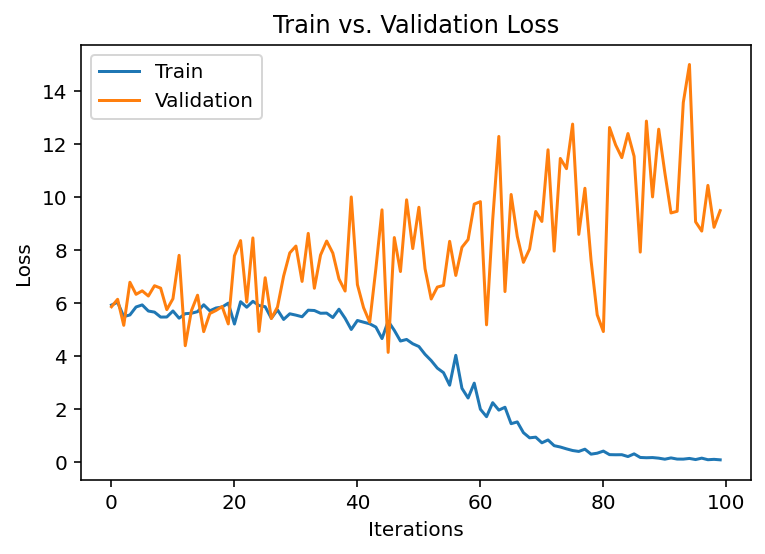

In [43]:
num_epochs = 100
learning_rate = 0.001 
batch_size = 32
emotion = "angry"

full_dataset = torch.utils.data.TensorDataset(inputs, outputs)
train_size = int(0.8 * len(full_dataset))
validation_size = len(full_dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(full_dataset, [train_size, validation_size])
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)
validation_loader = torch.utils.data.DataLoader(validation_dataset, shuffle=True, batch_size=32)

rnn_model = MusicRNN()
train(rnn_model, emotion, train_loader, validation_loader, batch_size, num_epochs, learning_rate)

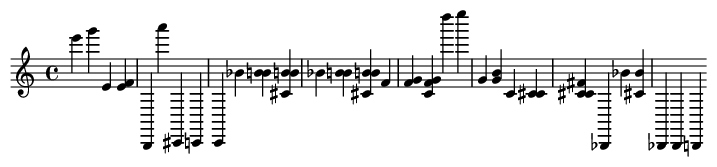

'Generated_Melody.mid'

In [28]:
# Display the image of the generated music
def show(music):
    display(Image(str(music.write("lily.png"))))

# Conver the list of notes/chords back to music     
def chords_n_notes(tune):
    melody = []
    offset = 0 
    for i in tune:
        # pattern is a chord then separate the chord into notes
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") 
            notes = [] 
            for j in chord_notes:
                inst_note = int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    melody_midi = stream.Stream(melody)   
    return melody_midi

# Primary model 
def melody_generator(note_count):
    # Generate seed 
    seq_length = note_count
    start = np.random.randint(0, len(notes) - seq_length)
    prompt = notes[start:start + seq_length]
    pattern = [note_to_index[c] for c in prompt]
    
    rnn_model.eval()
    with torch.no_grad():
        for i in range(1000):
            # format input array of int into PyTorch tensor
            x = np.reshape(pattern, (1, len(pattern), 1)) / float(length_unique_notes)
            x = torch.tensor(x, dtype=torch.float32)
            
            # generate logits as output from the model
            prediction = rnn_model(x)
            
            # convert logits into one character
            index = int(prediction.argmax())
            result = index_to_note[index]

            # append the new character into the prompt for the next iteration
            pattern.append(index)
            pattern = pattern[1:]
            music = [index_to_note[char] for char in pattern]

    # Now, we have music in form or a list of chords and notes and we want to be a midi file.
    melody = chords_n_notes(music)
    melody_midi = stream.Stream(melody)   
    return music, melody_midi


# getting the Notes and Melody created by the model
music, melody = melody_generator(20)
show(melody)

# To save the generated melody
melody.write('midi','Generated_Melody.mid')

# Baseline Model

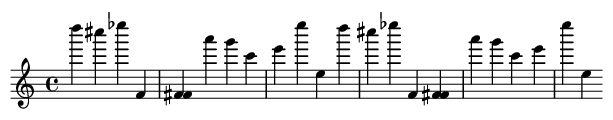

'Baseline_Generated_Melody.mid'

In [29]:
def count_occurence_of_note(notes):
    note_occurence_dictionary = {}
    for note in unique_notes: 
        count_note = notes.count(note)
        note_occurence_dictionary[note] = count_note
    sorted_note_occurence_dictionary = sorted(note_occurence_dictionary.items(), key=lambda x: x[1], reverse=True)
    return sorted_note_occurence_dictionary

sorted_note_occurence_dictionary = count_occurence_of_note(notes)


# Baseline model 
import math 
def Baseline_Model(Note_Count):
    Notes_Generated=[]
    num_repeat = math.floor(Note_Count/10)

    for i in range(num_repeat):
        for i in range(10):
            Notes_Generated.append(sorted_note_occurence_dictionary[i][0])
    
    Melody = chords_n_notes(Notes_Generated)
    Melody_midi = stream.Stream(Melody)   
    return Notes_Generated, Melody_midi

notes_generated, melody_midi = Baseline_Model(20)
show(melody_midi)

melody_midi.write('midi','Baseline_Generated_Melody.mid')